In [47]:
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
from ukbb_recessive.regression.regressions import read_results_excel
from ukbb_recessive.data_collection.variants import VariantFeatures
import ukbb_recessive.regression.plotting as plotting

sns.set_style("whitegrid")

import matplotlib

import glob

# Add fonts
plotting.add_fonts(['../../../data/fonts'])
plotting.configure_matplotlib()

plt.rc('font', size=plotting.SMALL_SIZE, family='Arimo')

Added: .../ukbb_recessive/data/fonts/Arimo-VariableFont_wght.ttf


# Prepare datasets

## PLP carriers

In [48]:
# samples of interest: European & non-related
european_non_rel_samples = (
    ".../450k/samples/european_non_related_no_withdrawal_to_include_450k.no_hom_comp_het.txt"
)

european_non_rel_samples = set([int(x) for x in pd.read_csv(european_non_rel_samples, header=None)[0].values.tolist()])
print ("Number of samples:", len(european_non_rel_samples))

Number of samples: 376608


In [49]:
sample_plps = glob.glob(".../450k/RAP_output_per_chr/filtered_plps/basic/new_gene_names/new_freq/new_relatedness/chr*")

# read information about the PLPs per sample
sample_plps = VariantFeatures().read_sample_plps(sample_plps, filter_homozygous=True)

# leave only European non-related samples
sample_plps = sample_plps[sample_plps['s'].isin(european_non_rel_samples)]
print ("Number of samples without plp:", len(european_non_rel_samples) - sample_plps['s'].nunique())

# calculate the number of PLPs per carrier
sample_plps.loc[:, 'AC'] = 1
per_sample_plp_count = sample_plps[['AC', 's']].groupby('s').sum().reset_index().rename(columns={'AC': 'plp_cnt'})

# add samples without PLPs
per_sample_plp_count = per_sample_plp_count.merge(pd.DataFrame({'s': list(european_non_rel_samples)}), how='outer').fillna(0)
print ("Average PLP per person:", per_sample_plp_count['plp_cnt'].mean())

# group by the number of PLPs
per_sample_plp_count = per_sample_plp_count.groupby('plp_cnt').count().reset_index()
per_sample_plp_count['plp_cnt'] = per_sample_plp_count['plp_cnt'].astype(int)

per_sample_plp_count = per_sample_plp_count.sort_values(by='plp_cnt')

per_sample_plp_count.head(3)

All PLPs in the cohort: 764216
Heterozygous PLPs in the cohort: 761211
Number of samples without plp: 65806
Average PLP per person: 1.8656905854363157


plp_cnt       s
0        0   65806
1        1  100767
2        2   98974

## PLP AF

In [50]:
def add_s_het_bin(s_het, bin_column='s_het_bin', n_bins=5):

    s_het[bin_column] = pd.qcut(s_het['s_het'], n_bins, precision=1)

    mybinlabels = {i: f'≤ {i.right}' for i in s_het.s_het_bin.cat.categories}
    last = s_het.s_het_bin.cat.categories[-1]
    mybinlabels[last] = f'> {last.left}'
    s_het[bin_column] = s_het[bin_column].cat.rename_categories(mybinlabels)

    return s_het

In [51]:
plps = pd.read_csv(
    ".../450k/plp_selection/basic/new_gene_names/new_freq/new_relatedness/all_chr_total_presumable_plps_HFE_final_sorted.txt", 
    sep='\t')

print ("Number of PLPs:", plps.shape[0])

# select PLPs
plps = plps[(plps['homs'] <= 0)]

# plps = plps[(plps['homs'] <= 0) & (plps['hets'] <= 20)]

plps = plps.groupby('gene').agg({'hets': 'max'}).reset_index()

s_het = pd.read_csv(".../450k/selection_roulette/s_het_roulette_gencode-v34.csv", sep='\t')
s_het = add_s_het_bin(s_het)

plps = plps.merge(s_het, how='inner', left_on='gene', right_on='gene_symbol')
print ("Number of PLPs in known s-het genes:", plps.shape[0])

Number of PLPs: 54758
Number of PLPs in known s-het genes: 1842


## Childlessness regressions on different variants sets

In [75]:
tables_folder = '../../../data/tables'
output_folder = '../../../data/plots'

results_path = f"{tables_folder}/table_selection_analysis.xlsx"

# load flat table
childlessness = read_results_excel(results_path, flatten_multiindex=True)

# leave only necessary s_het effect
childlessness = childlessness[childlessness['feature'].str.contains("s_het")]

# add odds ratio distance
childlessness = plotting.add_odds_ratio_intervals(childlessness)

In [76]:
# Dictionary to rename target columns
renaming_dict_target = {
    'is_blond': 'Hair color', 
    'childlessness': 'Childlessness'
}

# select targets of interest
childlessness = childlessness[childlessness['target'].isin(renaming_dict_target.keys())].copy()
childlessness['target'] = childlessness['target'].apply(lambda x: renaming_dict_target.get(x, x))

# select gender of interest
childlessness = childlessness[childlessness['gender'] == 'all']

# select dataset
childlessness = childlessness[childlessness['dataset'] == 'Roulette']

# select analyses
renaming_dict_analyses = {
    'selection regressions on [s_het_recessive_all]' : 'PLPs in recessive genes',
    'selection regressions on [s_het_lof_without_AR]' : 'Singleton LoFs in non-recessive genes',
    'exlude_lof_carriers regressions on [s_het_recessive_all]' : 'PLPs in recessive genes w/out LoF carriers'
}

childlessness = childlessness[childlessness['analysis'].isin(renaming_dict_analyses.keys())].copy()
childlessness['analysis'] = childlessness['analysis'].apply(lambda x: renaming_dict_analyses.get(x, x))

childlessness.head(3)

dataset               feature    effect  odds_ratio  odds_ratio_lower  \
27  Roulette   s_het_recessive_all  0.533132    1.704261          1.111429   
35  Roulette   s_het_recessive_all  0.216826    1.242128          0.727424   
43  Roulette  s_het_lof_without_AR  0.766382    2.151967          1.731414   

    odds_ratio_upper odds_ratio_pretty       p_value  p_value_corrected  \
27          2.613308        OR = 1.704  1.316271e-03       1.316271e-02   
35          2.121023        OR = 1.242  2.965785e-01       2.965785e+00   
43          2.674670        OR = 2.152  1.100615e-19       1.100615e-18   

    bonferroni_correction_coef  n_observations         target gender  \
27                          10          368224  Childlessness    all   
35                          10          369270     Hair color    all   
43                          10          374671  Childlessness    all   

                                 analysis  \
27                PLPs in recessive genes   
35                PLPs in recessive genes   
43  Singleton LoFs in non-recessive genes   

                                              formula    family  \
27  childlessness ~ s_het_recessive_all + age_at_r...  binomial   
35  is_blond ~ s_het_recessive_all + age_at_recrui...  binomial   
43  childlessness ~ s_het_lof_without_AR + age_at_...  binomial   

   p_value_pretty p_value_corrected_pretty  odds_ratio_lower_distance  \
27      1.32×10⁻³                    0.013                   0.592832   
35          0.297                        1                   0.514704   
43     1.10×10⁻¹⁹               1.10×10⁻¹⁸                   0.420553   

    odds_ratio_upper_distance  
27                   0.909047  
35                   0.878895  
43                   0.522704

# Plot

In [77]:
plps.sort_values(by='s_het')['s_het_bin'].unique()  

['≤ 0.01', '≤ 0.02', '≤ 0.04', '≤ 0.1', '> 0.1']
Categories (5, object): ['≤ 0.01' < '≤ 0.02' < '≤ 0.04' < '≤ 0.1' < '> 0.1']

In [88]:
# Create a function to format numbers with a comma as a thousand separator
def format_thousands(x):
    return f'{x:,.0f}'  # Use , as a thousand separator and format as integers


def plot_1a(ax):

    # return 

    sns.barplot(data=per_sample_plp_count, x='plp_cnt', y='s', ax=ax, color='#74C0D1', edgecolor='k', linewidth=0.5)

    # add the annotation
    # Format the y-data using the format_thousands function
    labels = [format_thousands(val) for val in ax.containers[-1].datavalues]
    ax.bar_label(ax.containers[-1],  label_type='edge', labels=labels, rotation=90, padding=3, fontsize=plotting.SMALL_SIZE)

    plotting.configure_axis(ax, x_label='Number of PLPs', y_label='Samples', format_x=False)


def plot_s_het_AF_per_gene(ax):
    sns.boxplot(data=plps.sort_values(by='s_het'), x='s_het_bin', y='hets', hue='s_het_bin', palette='light:salmon', linewidth=0.5, ax=ax, 
                linecolor='k', legend=None, 
                flierprops={"markersize": 0.2, "marker":'h', 'markerfacecolor': 'g', 'markeredgecolor': 'k'})


    plotting.configure_axis(ax, x_label='S-het per gene', y_label='PLPs highest AF\nper gene', format_x=False, ylim=(0.8, 10000))
    # plt.xticks(rotation=90)
    ax.set_yscale('log')
    # ax.set_ylim([0, 10000])


def plot_1b(ax, targets):

    y_order = targets
    group_order = ['Singleton LoFs in non-recessive genes', 'PLPs in recessive genes w/out LoF carriers', 'PLPs in recessive genes'][::-1]

    legend_kwargs = {
        "bbox_to_anchor": (0.0, 1., 1, .102), 
        "frameon": False,
        "mode": "expand", 
        "ncol": 1, 
        "labelspacing": 0.1, 
        "markerfirst": False, 
        'fontsize': plotting.MEDIUM_SIZE
    }

    # colors=['#B048B5', '#046307', '#FFAE42']
    colors=['#B048B5',  '#FF8225', '#046307',]

    plotted_data = plotting.plot_errorbar_grouped(df=childlessness[childlessness['target'].isin(targets)].copy(), 
                                        axis=ax, y_column='target', group_column = 'analysis',  
                                        legend_loc=None, 
                                        legend_kwargs=legend_kwargs,
                                        group_scale=0.01, 
                                        y_scale=0.04,
                                        colors=colors,
                                        y_order=y_order, 
                                        group_order=group_order
                                        )


    plotting.configure_axis(ax, x_label='OR (99% CI)', y_label=None, format_x=True, ymargin=0.5,)

    # Display p-values or any other information in the sidebar
    p_values = plotted_data['p_value_corrected_pretty']
    or_values = plotted_data['odds_ratio']
    positions = plotted_data['y']


    for i, (p, oddsr, pos) in enumerate(zip(p_values, or_values, positions)):
        ax.text(oddsr+0.05, pos+0.005, f'{oddsr:.2f}   {p}', va='center', size=plotting.MEDIUM_SIZE)


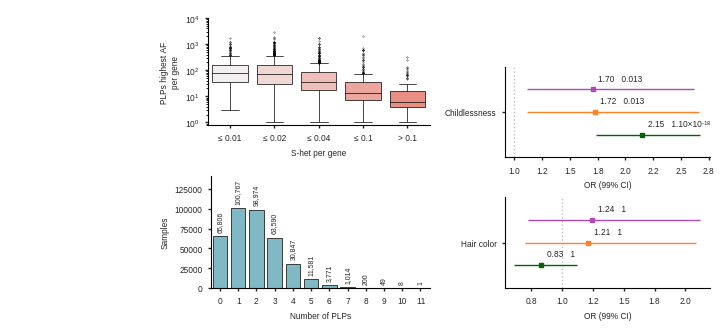

In [95]:
import matplotlib.ticker as ticker

cm = 1/2.54  # centimeters in inches
k = 1.
fig = plt.figure(constrained_layout=True, figsize=(18*cm*k, 8*cm*k))

# divide subfigure into left and right parts
subfigs = fig.subfigures(nrows=1, ncols=3, width_ratios=[0.5, 1, 1], wspace=0.03)

# divide left part into top and bottom subplots
subfigs_left = subfigs[1].subfigures(nrows=2, ncols=1, height_ratios=[2, 2], hspace=0.07)

# plot plp statistic on the top one
ax_1 = subfigs_left[0].subplots(1, 1)

plot_s_het_AF_per_gene(ax_1)

# plot plp statistic on the bottom one
ax_1 = subfigs_left[1].subplots(1, 1)

plot_1a(ax_1)

# plot regression analysis on the rigt part
ax = subfigs[2].subplots(3, 1, height_ratios=[0.5, 1, 1])
ax[0].axis('off')
plot_1b(ax[1], ['Childlessness'])
plot_1b(ax[2], ['Hair color'])


plt.savefig(f"{output_folder}/figure_1.pdf", format="pdf", bbox_inches="tight")

plt.show()